# Libraries

In [1]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn') # Seaborn Style

# Surprise Library (Collaborative Filtering)
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [2]:
# Leer el dataset
searching = pd.read_csv('data/search.csv')
searching.head()

,id_search,label,id_user,id_product,ts_search,ds_search,ds_purchased,ds_cart,query_market,query_delivery_date_start,query_delivery_end_date,query_delivery_radius,query_price_max,query_price_min,product_is_new,product_total_price,product_review_rating,product_review_count,product_type,product_recommended_items,product_has_video,product_recent_comments_count,product_recent_comments_count_90d,product_volume_discount,product_bundle_discount,product_short_term_price_factor,product_long_term_price_factor
0,1d320d4d-4826-42b6-9ebe-97d8f2adc543,impression,e566365a0638690cc6572c40e99729ac,6f6d6ba9c29e63a1fdb85742a598b5b5,11/26/18 17:18,11/26/18,NaN,NaN,Concepcion,4/24/19,4/29/19,0.744589,-1.0,-1,0,284.74063,4.729166,48.0,47.0,3.0,True,0,14.0,1,0,0.9,1.00
1,94f40f5e-5d7c-4593-b745-220c8db1070d,impression,e566365a0638690cc6572c40e99729ac,15eaa0a653431dfb2c80e3e031866e49,11/26/18 17:18,11/26/18,NaN,NaN,Concepcion,4/24/19,4/29/19,0.372312,-1.0,-1,0,228.57620,4.940299,67.0,NaN,4.0,True,0,NaN,0,0,1,1.00
2,e9649afc-d30a-4b77-bb0a-8cfd5c3423ea,impression,e566365a0638690cc6572c40e99729ac,69a48538dedb0975b59feaa6ba38567a,11/26/18 17:19,11/26/18,NaN,NaN,Concepcion,4/24/19,4/29/19,0.186147,-1.0,-1,0,208.72273,NaN,86.0,NaN,2.0,False,0,12.0,1,1,0.85,0.92
3,75c98fbc-84e9-4dde-b882-87f9985d1942,impression,e566365a0638690cc6572c40e99729ac,79b9a8296d922ad4ebbd44c511049b90,11/26/18 17:19,11/26/18,NaN,NaN,Concepcion,4/24/19,4/29/19,0.744608,-1.0,-1,0,NaN,4.642857,14.0,1.0,2.0,False,0,5.0,1,1,0.64,0.95
4,11886a08-c9da-4b41-98cd-8d4109a35779,impression,e566365a0638690cc6572c40e99729ac,cc68e4db29988e237131d93e022d7316,11/26/18 17:19,11/26/18,NaN,NaN,Concepcion,4/24/19,4/29/19,0.093075,-1.0,-1,0,326.53745,5.000000,1.0,35.0,3.0,False,0,0.0,0,0,NaN,NaN


In [3]:
searching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177588 entries, 0 to 177587
Data columns (total 27 columns):
id_search                            177588 non-null object
label                                177588 non-null object
id_user                              177588 non-null object
id_product                           177588 non-null object
ts_search                            177588 non-null object
ds_search                            177588 non-null object
ds_purchased                         2240 non-null object
ds_cart                              5273 non-null object
query_market                         177588 non-null object
query_delivery_date_start            177588 non-null object
query_delivery_end_date              177588 non-null object
query_delivery_radius                177588 non-null float64
query_price_max                      177588 non-null float64
query_price_min                      177588 non-null int64
product_is_new                       177588 non-null

In [4]:
print("Cantidad de Registros: ", searching.shape[0])
print("Cantidad de Atributos: ", searching.shape[1])

Cantidad de Registros:  177588
Cantidad de Atributos:  27


In [5]:
# Missing values
total = searching.isnull().sum().sort_values(ascending=False)
percent = round((searching.isnull().sum() / searching.isnull().count()) * 100, 2).sort_values(ascending=False)
missing_values = pd.DataFrame({'Total':total, 'Percent':percent})
missing_values = missing_values[missing_values['Percent'] > 0]
missing_values

,Total,Percent
ds_purchased,175348,98.74
ds_cart,172315,97.03
product_short_term_price_factor,46630,26.26
product_long_term_price_factor,44878,25.27
product_recent_comments_count_90d,24800,13.96
product_review_rating,21382,12.04
product_review_count,17533,9.87
product_has_video,9560,5.38
product_recommended_items,9050,5.10
product_total_price,9021,5.08


Se preocede a eliminar las columnas `ds_purchased` y `ds_cart`, debido a que tienen casi el __100%__ de datos perdidos y no se va a considerar realizar imputaciones eventualmente.

In [6]:
searching['product_short_term_price_factor'] = searching['product_short_term_price_factor'].str.strip()
searching['product_short_term_price_factor'] = pd.to_numeric(searching['product_short_term_price_factor'])
searching['product_short_term_price_factor'] = searching['product_short_term_price_factor'].fillna(searching['product_short_term_price_factor']\
                                                                                                   .median())

Imputación de la columna por la moda, al no estar tan seguro de cómo puede influenciar este valor con respecto a otra columna sustituyo por dicha moda y no por el promedio o 0.

In [7]:
searching['product_long_term_price_factor'] = pd.to_numeric(searching['product_long_term_price_factor'])
searching['product_long_term_price_factor'] = searching['product_long_term_price_factor'].fillna(searching['product_long_term_price_factor']\
                                                                                                 .median())

Mismo procedimiento para este caso que el anterior, al no estar tan seguro de cómo puede influenciar este valor con respecto a otra columna sustituyo por la moda y no por el promedio o 0.

In [8]:
searching['product_recent_comments_count_90d'] = pd.to_numeric(searching['product_recent_comments_count_90d'])
searching['product_recent_comments_count_90d'] = searching['product_recent_comments_count_90d'].fillna(0)

Se imputó la columna `product_recent_comments_count_90d` con 0 para aquellos valores perdidos, representando que no hubo comentarios en una página de producto en los últimos 90 días.

In [9]:
searching['product_review_rating'] = searching['product_review_rating'].fillna(searching['product_review_rating'].mean())

Se sustituyeron los valores perdidos por la media de dicha columna.

In [10]:
searching['product_review_count'] = searching['product_review_count'].fillna(searching['product_review_count'].median())

Se imputó la columna por la moda, donde esta es 6.

In [11]:
searching['product_has_video'] = searching['product_has_video'].fillna(False)

Sustitución de los valores perdidos, para este caso se sustituyeron por `False` ya que es la categoría con mayor cantidad.

In [12]:
searching['product_recommended_items'] = searching['product_recommended_items'].fillna(searching['product_recommended_items']\
                                                                                       .median())

La imputación para este columna fue por la moda de la cantidad de productos relacionados por la página del producto, no se tomó la media ya que no se puede mostrar productos a mitad, es decir, mostrar 2 productos y medios por página.

In [13]:
searching['product_total_price'] = searching['product_total_price'].fillna(searching['product_total_price'].mean())

Imputación de la columna por la media o promedio del total de precio por producto

In [14]:
searching['product_type'] = searching['product_type'].fillna(searching['product_type'].median())

Para este caso la imputación de la columna fue por la moda, ya que es una variable categórica, la categoría que más se repetía era __1__.

In [15]:
# Eliminación de columnas no relevantes para este análisis
searching.drop(columns=['id_search', 'ds_purchased', 'ds_cart'], inplace=True)

Para esta ocasión procedí a eliminar las siguientes columnas (`id_search`, `ds_purchased`, `ds_cart`), el motivo es que hay un gran porcentaje en los datos perdidos y no puede realizar algún tipo de imputación para generar hipótesis eventualmente. Además, son datos muy relevantes en cuanto a la compra de un producto.

# 1. Performing exploratory analyses to include new features and transformations

In [16]:
searching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177588 entries, 0 to 177587
Data columns (total 24 columns):
label                                177588 non-null object
id_user                              177588 non-null object
id_product                           177588 non-null object
ts_search                            177588 non-null object
ds_search                            177588 non-null object
query_market                         177588 non-null object
query_delivery_date_start            177588 non-null object
query_delivery_end_date              177588 non-null object
query_delivery_radius                177588 non-null float64
query_price_max                      177588 non-null float64
query_price_min                      177588 non-null int64
product_is_new                       177588 non-null int64
product_total_price                  177588 non-null float64
product_review_rating                177588 non-null float64
product_review_count                 177588 non

In [17]:
searching.describe()

,query_delivery_radius,query_price_max,query_price_min,product_is_new,product_total_price,product_review_rating,product_review_count,product_type,product_recommended_items,product_recent_comments_count,product_recent_comments_count_90d,product_volume_discount,product_bundle_discount,product_short_term_price_factor,product_long_term_price_factor
count,177588.000000,1.775880e+05,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000,177588.000000
mean,15.634096,1.284573e+07,4.711563,0.193752,713.949730,3.427163,20.867384,8.492224,2.693003,0.000957,4.785019,0.583609,0.571643,0.801000,0.917391
std,97.100965,1.165330e+08,37.856419,0.395238,2389.207806,2.017389,36.406369,15.799292,2.508858,0.033713,7.178061,0.492961,0.494842,0.057082,0.064823
min,0.021910,-1.000000e+00,-1.000000,0.000000,7.731437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.130000
25%,0.860849,-1.000000e+00,-1.000000,0.000000,143.932630,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.900000
50%,1.935646,-1.000000e+00,-1.000000,0.000000,331.701995,4.625000,6.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.800000,0.920000
75%,12.771826,5.100000e+01,0.000000,0.000000,713.949730,4.909091,24.000000,2.000000,3.000000,0.000000,8.000000,1.000000,1.000000,0.800000,0.950000
max,5522.825700,1.070000e+09,2758.000000,1.000000,525960.060000,5.000000,462.000000,70.000000,50.000000,2.000000,64.000000,1.000000,1.000000,1.000000,1.000000


Siguiendo con el estudio de algunos atributos, se aprecian casos de anomalía en cuanto a los precios en las queries, por tal motivo, realizaré una depuración donde voy a seleccionar aquellos registros que sus atributos `query_price_min` y `query_price_max` estén entre 0 y 1000, lo limito hasta este monto, debido a que hay registros que son outliers, como desconozco la moneda, voy asumir que es en USD $, y parece un poco extraño gastar más de ese monto, principalmente como están distribuido los datos.

In [18]:
# Depurar dataframe
searching = searching[(searching['query_price_min'] > 0) & (searching['query_price_min'] <= 1000)]
searching = searching[(searching['query_price_max'] > 0) & (searching['query_price_max'] <= 1000)]

### Product Total Price Distribution

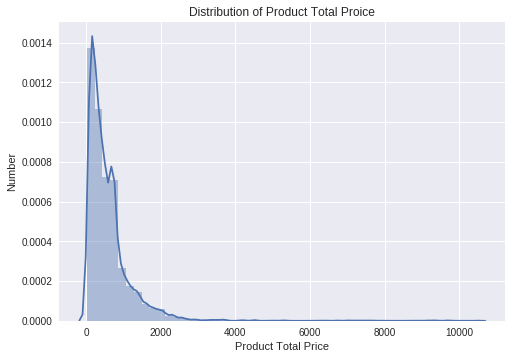

In [19]:
sns.distplot(searching['product_total_price'])
plt.xlabel("Product Total Price")
plt.ylabel("Number")
plt.title("Distribution of Product Total Proice")
plt.savefig("imgs/distributionProductTotalPrice1");

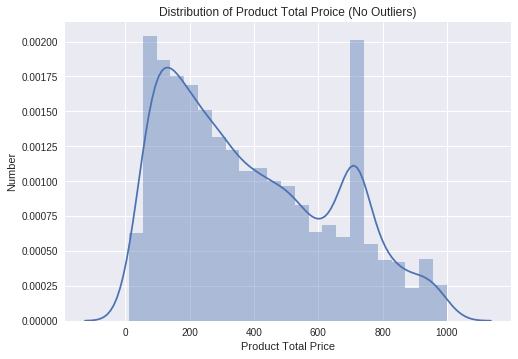

In [20]:
# Removiendo outliers
searching = searching[searching['product_total_price'] <= 1000]

sns.distplot(searching['product_total_price'])
plt.xlabel("Product Total Price")
plt.ylabel("Number")
plt.title("Distribution of Product Total Proice (No Outliers)")
plt.savefig("imgs/distributionProductTotalPrice_No_Outliers");

Inicialmente la variable `product_total_price` tenía registros que representaban outliers, debido a que el valor de la compra por cada uno de ellos registraba un número muy alto (desde 2000 a 50000, muy raro para ser en USD), por tal motivo hice un filtro donde sólo estoy considerando los registros que tienen un valor de compra menor igual a 1000, asumiré para este caso que la moneda es en USD $, si fuese en pesos chilenos (CLP) no sería tan raro hacer compras por más de 10.000 por la página web. De esta manera voy filtrando mi dataset con datos más reales.

In [21]:
searching.shape

(7357, 24)

### Product Type Distribution

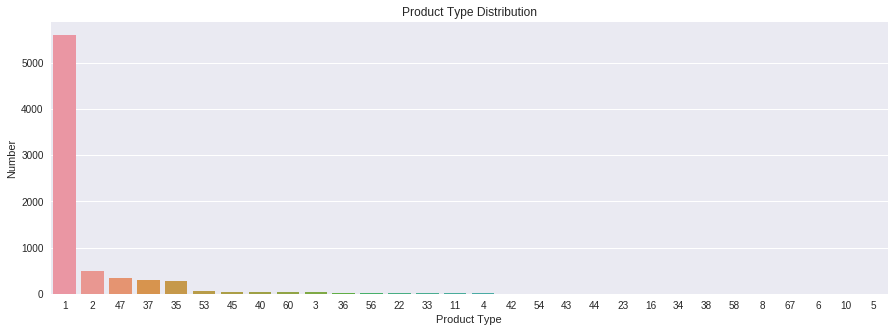

In [22]:
plt.figure(figsize=(15, 5))
searching['product_type'] = searching['product_type'].astype(int)
sns.countplot(x='product_type', data=searching, order=searching['product_type'].value_counts().index)
plt.xlabel("Product Type")
plt.ylabel("Number")
plt.title("Product Type Distribution")
plt.savefig("imgs/productType_Distribution");

El tipo de producto más vendido por la tienda es el `1` representado por un __76%__, seguido por la categoría `2` con un __7%__, por su contraparte podemos observar como las categorías `10` y `5` son las que menos han sido adquiridas por los clientes.

### Rating Distribution

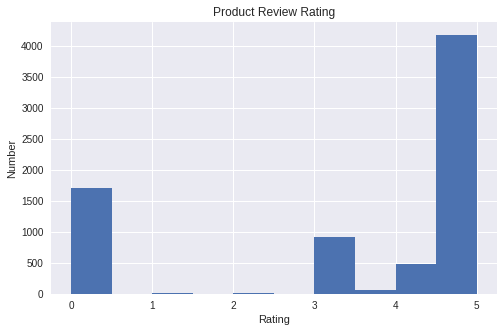

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(searching['product_review_rating'])
plt.xlabel("Rating")
plt.ylabel("Number")
plt.title("Product Review Rating")
plt.savefig("imgs/productReviewRating");

De acuerdo al Histograma de Rating por Producto, la mayor cantidad se encuentra concentrada desde 4.5 a 5, es importante tener en cuenta que han evaluado como mal aquellos productos que tienen mucho menos rating con 1 y 2 pero lo curioso de esto, es que han seleccionado al 0 dentro de la escala, es decir, hay una parte considerable que está manifestando su inconformidad total en aquellos productos evaluados con 0.

### Raiting Distribution by Product Type

In [24]:
searching['product_type'] = searching['product_type'].astype(int)
searching['product_type'] = searching['product_type'].astype(str)

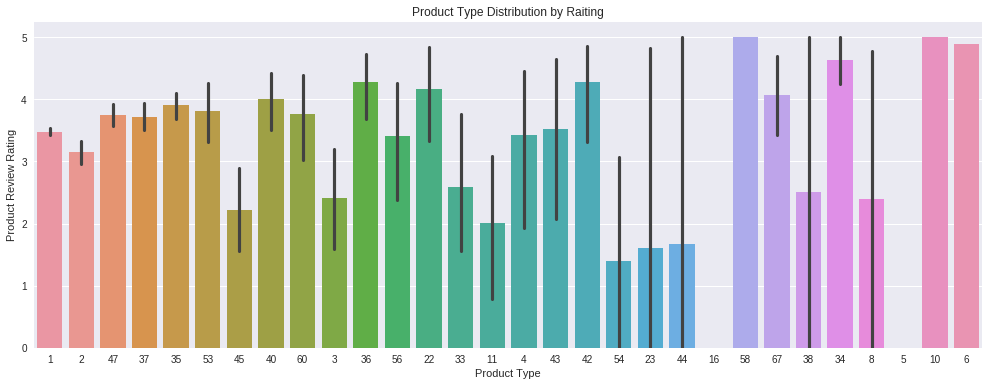

In [25]:
plt.figure(figsize=(17, 6))
sns.barplot(x='product_type', y='product_review_rating', data=searching, order=searching['product_type'].value_counts().index)
plt.xlabel("Product Type")
plt.ylabel("Product Review Rating")
plt.title("Product Type Distribution by Raiting")
plt.savefig("imgs/productType_by_Rating");

Se puede apreciar de qué manera están evaluados los productos de acuerdo a su categoría, actualmente se desconce con exactitud cual es el tipo de producto por lo que nos referiremos a ellos por número, los productos `58` `10` y `6` son los que mejor rating tienen, entre un rango de 4.7 a 5 aprox, es lógico que ocurra esto debido a que como vimos anteriormente, estos productos son los que menos han sido adquiridos y fueron evaluados, por tal motivo su rating es alto; por otra parte, los que peor rating tiene son los productos `54`, `16` y `5`, también se debe a que son productos con un bajo consumo y que han sido evaluados muy pocas veces.

### Product Type Distribution by Product Price

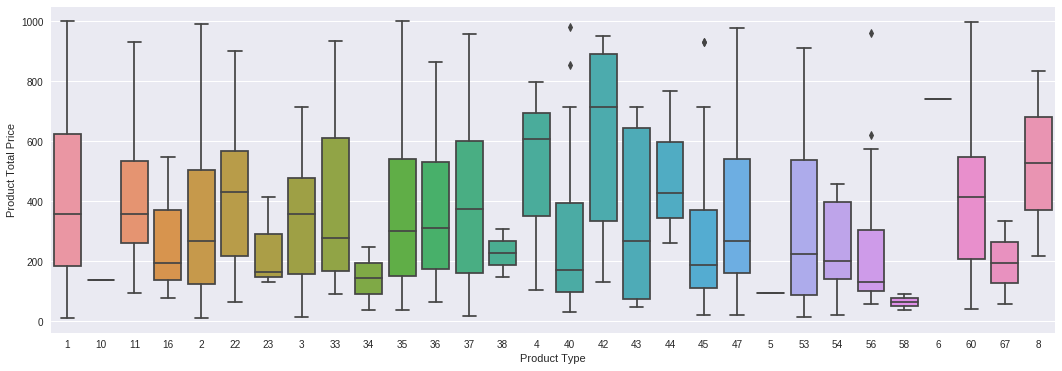

In [26]:
plt.figure(figsize=(18, 6))
sns.boxplot(x='product_type', y='product_total_price', data=searching)
plt.xlabel("Product Type")
plt.ylabel("Product Total Price")
plt.savefig("imgs/productType_Distribution(average)");

El siguiente gráfico representa como está distribuida la compra por tipo de producto de los clientes y el promedio en cada una de ellas, tomando en cuenta como está contemplado las compras por categorías, el tipo de producto `1` que representa la mayor cantidad de compras, su rango oscila entre los 200 a un poco más de los 610 aprox, teniendo una media de 380 aprox. Por otra parte, categorías como la `43`con poco consumo, tiene un rango de oscilación entre 150 a 620 aprox, y la categoría `58` tiene poca cantidad y su valor  es alrededor de 100 como media aprox.

### Label Distribution

In [27]:
searching['label'].value_counts()

impression     5013
click          2103
purchase        143
add_to_cart      98
Name: label, dtype: int64

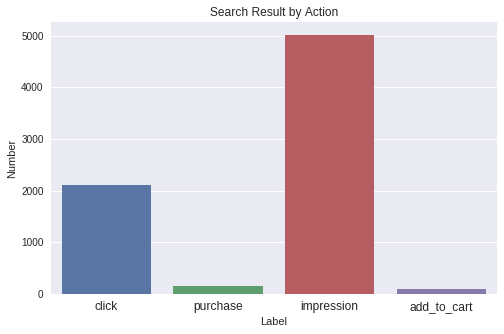

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=searching)
plt.xlabel("Label")
plt.xticks(size=12)
plt.ylabel("Number")
plt.title("Search Result by Action")
plt.savefig("imgs/searchResultAction");

In [29]:
searching.label.value_counts('%')

impression     0.681392
click          0.285850
purchase       0.019437
add_to_cart    0.013321
Name: label, dtype: float64

Los usuarios de este dataset tienden a realizar las búsquedas en su mayoría por la categoría `impression` la cual representa el 68%, seguida de `click` con 29%, `purchase` con el 2% y finalmente `add_to_cart` 1%.

### Label Distribution by Product Price (Average)

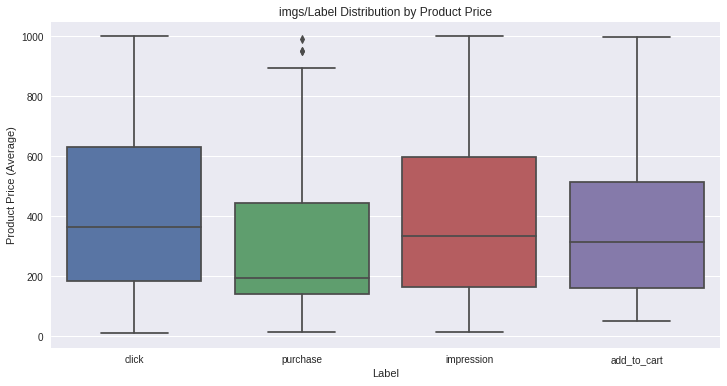

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='product_total_price', data=searching)
plt.xlabel("Label")
plt.ylabel("Product Price (Average)")
plt.title("imgs/Label Distribution by Product Price");

De acuerdo al gráfico previo, el promedio de las compras de los clientes es superior cuando hacen búsquedas de tipo `click`, lo que resulta interesante ya que en la distribución de estás búsquedas, la categoría `impression` es la que más cantidad tiene, es decir, en términos generales `click`es más efectiva que las otras.

### New Product Distribution

In [31]:
searching['product_is_new'].value_counts('%')

0    0.821123
1    0.178877
Name: product_is_new, dtype: float64

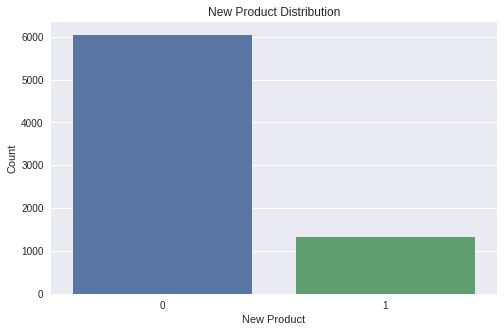

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(x='product_is_new', data=searching)
plt.xlabel("New Product")
plt.ylabel("Count")
plt.title("New Product Distribution")
plt.savefig("imgs/newProduct");

El gráfico previo indica la cantidad de productos que son nuevos, asumiendo que 1 es verdadero y 0 aquellos productos que tienen rating y reviews, el porcentaje de ellos es de 17% y 83% respectivamente.

In [33]:
searching[(searching['product_is_new'] == 1) & (searching['product_review_count'] == 0) \
          & (searching['product_total_price'] == 0)].head()

,label,id_user,id_product,ts_search,ds_search,query_market,query_delivery_date_start,query_delivery_end_date,query_delivery_radius,query_price_max,query_price_min,product_is_new,product_total_price,product_review_rating,product_review_count,product_type,product_recommended_items,product_has_video,product_recent_comments_count,product_recent_comments_count_90d,product_volume_discount,product_bundle_discount,product_short_term_price_factor,product_long_term_price_factor


De acuerdo a la descripción del diccionario de datos (word) para ser un producto nuevo, debe cumplir con las condiciones que son, el producto no tenga __reviews__ y __purchases__ en este caso no se cumple este axioma, por lo tanto estos productos no serían nuevo, es decir, como mínimo tuvo que haber una compra independientemente si fue evaluado, porque cuando uno evalua un producto es porque fue adquirido y tuvo una experiencia sea positiva o negativa.

### Product Video Distribution

In [34]:
# Recodificación del atributo
searching['product_has_video'] = np.where(searching['product_has_video'] == True, 1, 0)
searching['product_has_video'].value_counts('%')

0    0.922523
1    0.077477
Name: product_has_video, dtype: float64

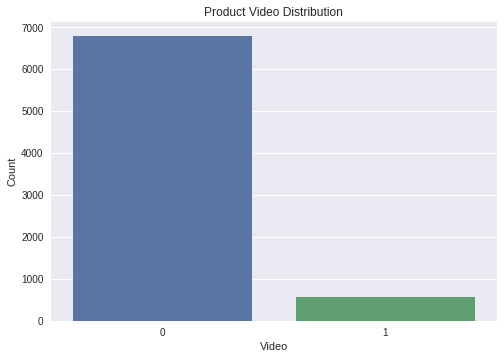

In [35]:
sns.countplot(x='product_has_video', data=searching)
plt.xlabel("Video")
plt.ylabel("Count")
plt.title("Product Video Distribution")
plt.savefig("imgs/productVideo");

Los productos que se encuentran en el dataset que no tienen vídeo representan un 92%, por el contrario, cuando tienen representan el 8%

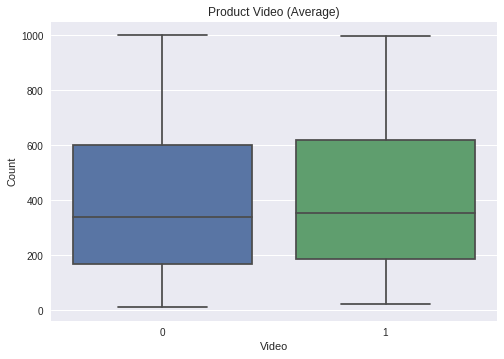

In [36]:
sns.boxplot(x='product_has_video', y='product_total_price', data=searching)
plt.xlabel("Video")
plt.ylabel("Count")
plt.title("Product Video (Average)")
plt.savefig("imgs/productVideoAverage");

Si bien sabemos, que las clases están desbalanceadas en cuanto a tener vídeo el producto, en este gráfico se observa como los pocos productos que tienen vídeo el rango de oscilación es levemente superior al que no, y la media es de 360 aprox, como hipótesis se pudiera decir, ¿Qué pasaría si agrego un vídeo a cada producto, aumentará el promedio de venta significativamente?

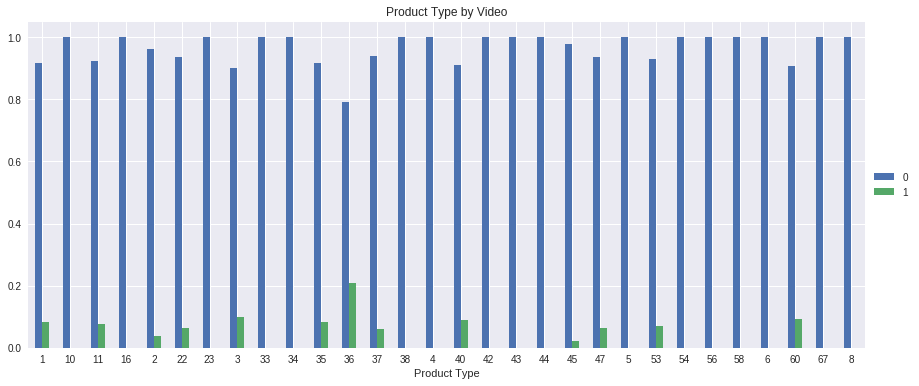

In [37]:
table = pd.crosstab(searching['product_type'], searching['product_has_video'])
table.div(table.sum(1), axis=0).plot(kind='bar', figsize=(15, 6))
plt.xlabel("Product Type")
plt.xticks(rotation=0)
plt.title("Product Type by Video")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.savefig("imgs/productType_Video");

De acuerdo al gráfico anterior, donde los productos que tienen vídeo su promedio de venta es mayor, quise ser un poco más exhaustivo para ver que tanto influye en cada tipo de producto, es evidenete que debido al desbalanceo de clases el porcentaje de `1` (tiene vídeo) es mucho menor, lo curioso que para la categoría `36` puede ser que el tener vídeo influya en el porcentaje de rating, ya que su evaluación en promedio es de 4,2 aprox.

### Product Type by Video and Product Price (Average)

In [38]:
pivot = pd.pivot_table(searching, index='product_type', 
                       columns='product_has_video', 
                       values='product_total_price',
                       aggfunc='mean')

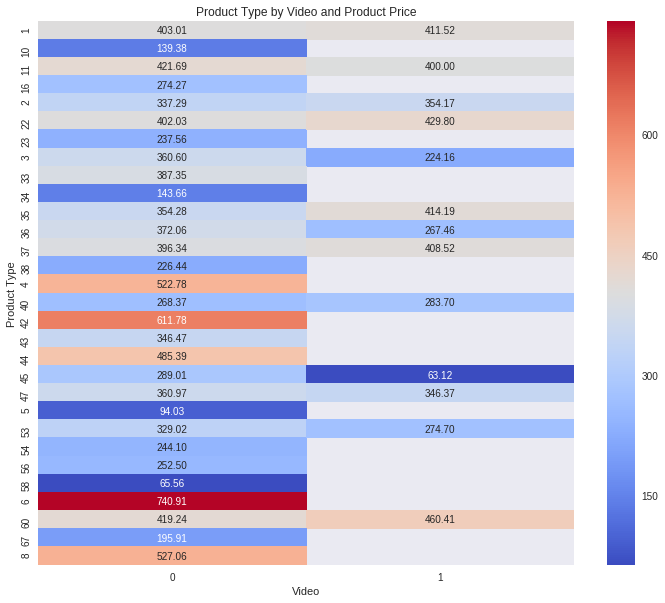

In [39]:
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Video")
plt.ylabel("Product Type")
plt.title("Product Type by Video and Product Price")
plt.savefig("imgs/productType_video_price");

Sabemos el desbalanceo que existe en las clases cuando el producto tiene vídeo o no, yendo un poco más a profundidad si bien hay partes donde no se puede comparar el tipo de producto, existen algunos que sí, resulta curioso como en la mayoría que pueden ser comparables, el tener vídeo, aumenta el promedio de venta.

### Product Type by Search Result and Product Price (Average)

In [40]:
pivot = pd.pivot_table(searching,
                       index='product_type',
                       columns='label',
                       values='product_total_price',
                       aggfunc='mean')

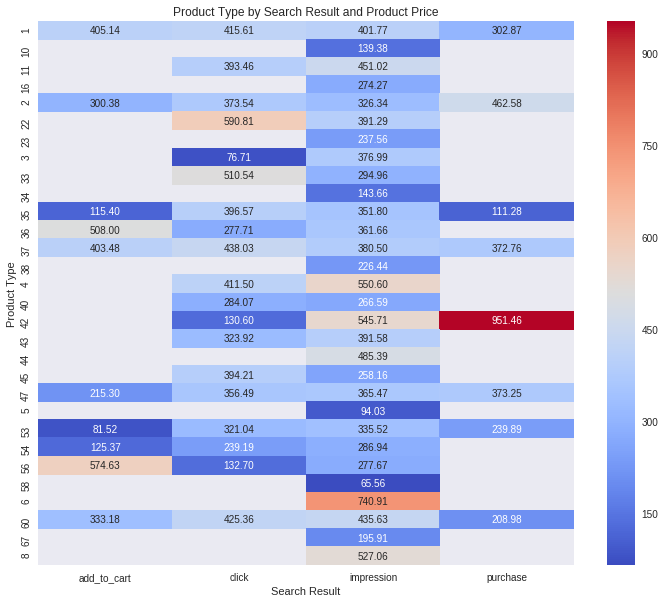

In [41]:
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Search Result")
plt.ylabel("Product Type")
plt.title("Product Type by Search Result and Product Price")
plt.savefig("imgs/productType_label_price");

El presente gráfico es para mostrar que tanto impacto tiene la manera en que los clientes buscan los productos de acuerdo a su categoría, acá podemos apreciar de qué manera está distribuido el promedio de venta por medio de la búsqueda, a pesar de que la categoría `click` es la más efectiva, los promedio de ventas no se inclinan hacia ella y también hay que considerar que es el 30% aprox de dichas ventas.

### Product Type by Review

In [42]:
product_guests = searching.groupby('product_type')['product_review_count'].count().reset_index()
product_guests.sort_values(by='product_review_count', ascending=False, inplace=True)

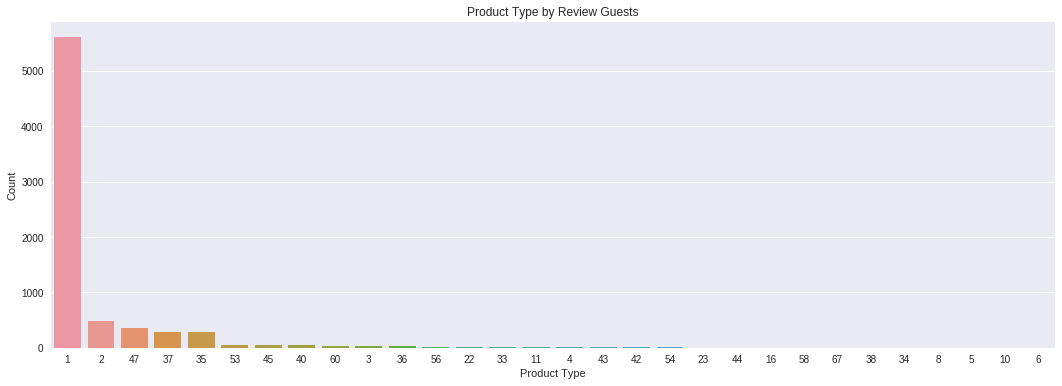

In [43]:
plt.figure(figsize=(18, 6))
sns.barplot(x='product_type', y='product_review_count', data=product_guests, \
            order=searching['product_type'].value_counts().index)
plt.xlabel("Product Type")
plt.ylabel("Count")
plt.title("Product Type by Review Guests")
plt.savefig("imgs/productType_ReviewGuests");

En el siguiente gáfico se puede apreciar cuales han sido las categorías más evaluadas por los Guests, siendo la `1`con el mayor porcentaje, es lógico esta diferencia que existe entre las demás, debido a que como vimos anteriormente dicha categoría es la que más cantidad o compras tiene.

### Products by Monthly Discount

1    0.575506
0    0.424494
Name: product_volume_discount, dtype: float64


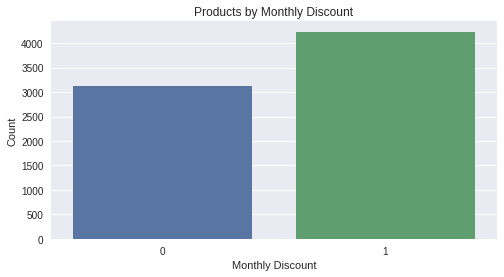

In [44]:
plt.figure(figsize=(8, 4))
sns.countplot(x='product_volume_discount', data=searching)
plt.xlabel("Monthly Discount")
plt.ylabel("Count")
plt.title("Products by Monthly Discount")
plt.savefig("imgs/products_MonthlyDiscount");
print(searching['product_volume_discount'].value_counts('%'))

El siguiente gráfico representa la cantidad de productos que tienen un descuento mensual, asumiendo que 1 es positivo, el porcentaje de representación es del 58%, es decir, hay productos que son mayoría y cuentan con esta condición.

### Product Type by Monthly Discount and Price (Average)

In [45]:
pivot = pd.pivot_table(searching, 
                       index='product_type',
                       columns='product_volume_discount',
                       values='product_total_price',
                       aggfunc='mean'
                      )

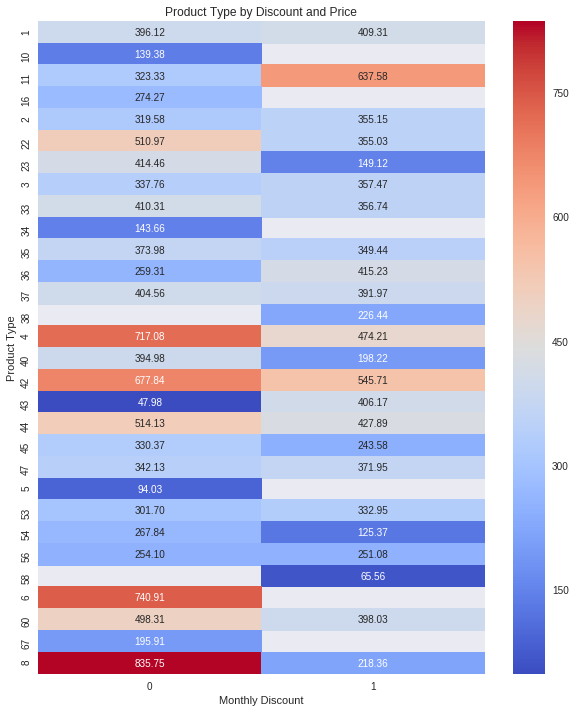

In [46]:
plt.figure(figsize=(10, 12))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Monthly Discount")
plt.ylabel("Product Type")
plt.title("Product Type by Discount and Price")
plt.savefig("imgs/productType_DiscountPrice");

En la siguiente tabla apreciamos como está distribuido el promedio de venta por categoría de producto cuando tienen un descuento mensual, también podemos apreciar como la categoría `1` (más evaluada), cuando tiene descuento su promedio es mayor pero ligeramente, es decir, que los productos que están en dicha categoría se venden de igual manera teniendo o no descuento mensual.

### Products by Weekly Discount Host

1    0.565584
0    0.434416
Name: product_bundle_discount, dtype: float64


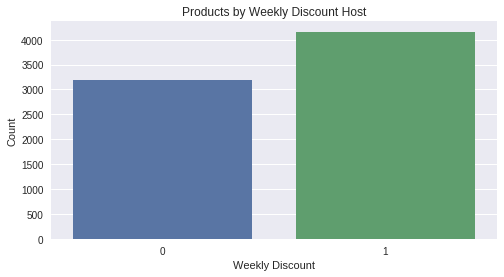

In [47]:
plt.figure(figsize=(8, 4))
sns.countplot(x='product_bundle_discount', data=searching)
plt.xlabel("Weekly Discount")
plt.ylabel("Count")
plt.title("Products by Weekly Discount Host")
plt.savefig("imgs/products_WeeklyDiscount");
print(searching['product_bundle_discount'].value_counts('%'))

De igual manera al gráfico anterior, las categorías que tienen un descuento semanal por el dueño está representado por un 57%, asumiento que 1 es positivo, posiblemente está condición se esté repitiendo en los descuentos mensuales de los productos respecto a su categoría.

### Product Type by Weekly Discount Host and Price (Average)

In [48]:
pivot = pd.pivot_table(searching, 
                       index='product_type',
                       columns='product_bundle_discount',
                       values='product_total_price',
                       aggfunc='mean'
                      )

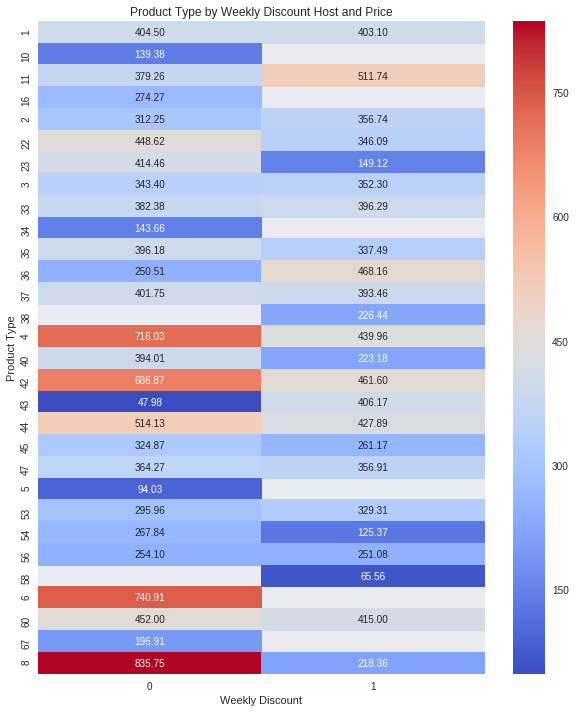

In [49]:
plt.figure(figsize=(10, 12))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel("Weekly Discount")
plt.ylabel("Product Type")
plt.title("Product Type by Weekly Discount Host and Price")
plt.savefig("imgs/productType_DiscountPriceWeekly");

Comparando con el gráfico mensual, los productos de la categoría `1` cuando no tiene descuento semanales su promedio de venta es ligeramente superior a cuando hay.

### Market of user search (City)

In [50]:
searching['query_market'].value_counts('%')

Concepcion     0.821666
Antofagasta    0.178334
Name: query_market, dtype: float64

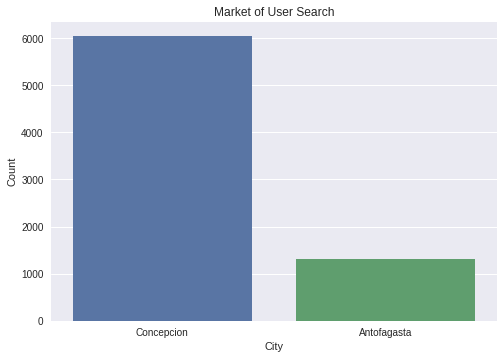

In [51]:
sns.countplot(x='query_market', data=searching)
plt.xlabel("City")
plt.ylabel("Count")
plt.title("Market of User Search")
plt.savefig("imgs/marketCity");

Los clientes que se encuentran en este dataset están dividos en 2 ciudades `Concepción`y `Antofagasta`, representadas por un 82% y 18% respectivamente.

### Market of User Search by Price

In [52]:
table = pd.pivot_table(searching, index='product_type', 
                       columns='query_market',
                       values='product_total_price',
                       aggfunc='mean')

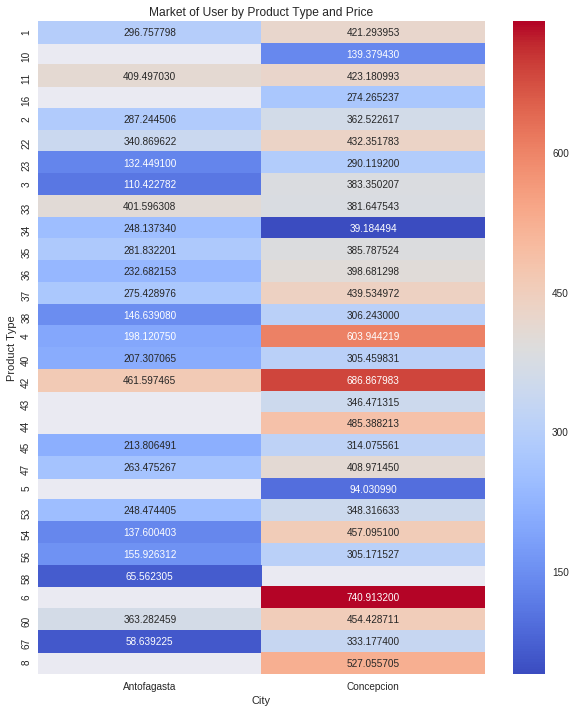

In [53]:
plt.figure(figsize=(10, 12))
sns.heatmap(table, annot=True, fmt='f', cmap='coolwarm')
plt.xlabel("City")
plt.ylabel("Product Type")
plt.title("Market of User by Product Type and Price")
plt.savefig("imgs/userMarket_Price");

Podemos apreciar en la tabla cual es el promedio de venta por tipo de producto de acuerdo a la ciudad del cliente, tomando 3 casos de la ciudad de `Concepción`, `6` `42` y `4`, la diferencia entre ellos es relevante, por el lado de `Antofagasta`, los tipos de producto `11` y `33`, la diferencia con respecto a `Concepción` es considerable también. Tal vez, estos productos estén relacionados al tipo de ambiente, vida social, u otro factor que contempla la ciudad.

### Correlation

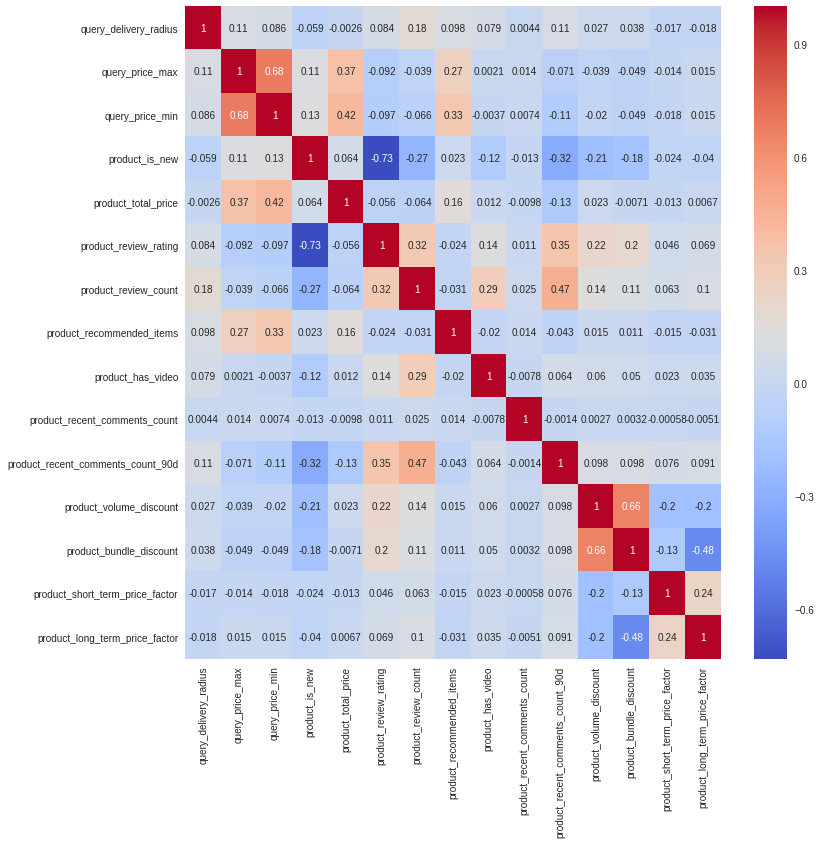

In [54]:
# Correlation
searching_corr = searching.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(searching_corr, annot=True, cmap='coolwarm')
plt.savefig("imgs/correlations");

De acuerdo al heatmap, existen varios atributos que están correlacionados entre sí como `query_min_price` con `query_max_price`,`product_bundle_discount` con `product_volume_discount` puede ser que se deba a que muchos de esos productos tengan ambos descuentos, y `product_review_count` con `product_recent_comment_count_90d` posiblemente porque las personas que evaluan un producto también dejan un comentario.

### 2. Redesigning the transformation pipeline for input data

### Training & Testing
En esta sección estaré implementando algoritmos basado en `Collaborative Filtering`, eventualmente haré una evaluación sobre el comportamiento del algoritmo vencedor, es importante mencionar que en primera instancia se hará una implementación `Vanilla` de cada uno de los algoritmos, posteriormente una búsqueda de hiperparámetros `GridSearch` para obtener valores optimizados (los mejores) y se evaluara en la data test (previamente se hará un `train_test_split`

In [57]:
search = searching.copy()
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(search[['id_user', 'id_product', 'product_review_rating']], reader)

In [58]:
# Splitting Data
trainset, testset = train_test_split(data, test_size=.30, random_state=123)

### 3. Redesigning the search algorithm
#### Surprise Library (Collaborative Filtering) Algo's

In [59]:
# Benchmark para saber que algoritmo tiene mejor comportamiento y seleccionarlo
benchmark = []

# Iteramos sobre los algoritmos
for algorithm in [SVD(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Comportamiento del cruce de validación
    results = cross_validate(algorithm, data, measures=['rmse'], cv=5, n_jobs=-1, verbose=False)
    
    # Obtener resultados y agregamos el nombre del algoritmo
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.833968,0.628997,0.018339
KNNWithMeans,1.853816,0.008640,0.015630
KNNBasic,1.855723,0.003691,0.015728
KNNWithZScore,1.862651,0.023658,0.015879
NormalPredictor,2.505431,0.009670,0.015400


Nuestro algoritmo vencedor fue `SVD`, ahora procederé a buscar los mejores valores y entrenar el modelo con ellos.

In [60]:
# GridSearchCV
param_grid = {'n_epochs': [5, 10, 15, 20], 
              'lr_all': [0.002, 0.005, 0.01, 0.1, 0.5],
              'reg_all': [0.4, 0.6, 0.8, 1]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)

grid_search.fit(data)

In [61]:
print("Best Score: ", grid_search.best_score)
print("Best Params: ", grid_search.best_params)

Best Score:  {'rmse': 1.7041472488465537}
Best Params:  {'rmse': {'n_epochs': 20, 'lr_all': 0.1, 'reg_all': 0.6}}


Una vez optimizados los hiperparametros del algoritmo, se procede a calcular el `RMSE`  

In [62]:
algo = grid_search.best_estimator['rmse']
predictions = algo.fit(trainset).test(testset)

In [63]:
accuracy.rmse(predictions)

RMSE: 1.7380


1.7380070283579108

Para inspeccionar las predicciones detalladamente se construirá un dataframe, este pedazo de código lo extraje de este [Notebook](https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb)

In [64]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [66]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

#### Podemos apreciar las mejores predicciones del modelo
Esto lo que indica, la estimación que hace el modelo por usuario y luego calcula el error de cada una de ella, y lo ordena de forma ascendente.

* `uid`: Código del Usuario
* `iid`: Código del Producto
* `rui`: Rating por el usuario
* `est`: Estimación del modelo
* `details`: Detalles de la predicción
* `Iu`: Cantidad de Productos evaluados por el usuario
* `Ui`: Cantidad de usuarios que evaluaron el producto

In [87]:
# Mejores Predicciones
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1832,ddc138d04df58110895c8a32fadb008a,0bc470d1bddba5c5dd385d26cff00f08,4.666666,4.670138,{'was_impossible': False},1,2,0.003471
476,7074d95bba930147d184667eaf7f3ee8,304ca3fe46b774644d08e0409c2c150d,3.427163,3.431084,{'was_impossible': False},30,1,0.003921
1008,55091e91fb28e4624fb3172e7a5f2a7b,7670a14352097b55b674c510bf18bdd2,3.427163,3.431174,{'was_impossible': False},69,2,0.004011
1922,40f7654a9c9182081bcd091afd0828ba,4519098eb199aeea1d4df93222ed1d74,4.038462,4.032618,{'was_impossible': False},86,1,0.005844
558,a623309f49a281c9fe681b8ba704f6bc,45c2c8a97fd88b7f5a6f16d6a00e3412,3.427163,3.419457,{'was_impossible': False},27,2,0.007706
1445,9fb6df773e41971e5818c758775001bc,7091a4831c76323c567e6873315f3b33,3.000000,2.991617,{'was_impossible': False},62,0,0.008383
65,f5b8f707f6fb50e6c7b93e55ace3d880,d48c1899894626f79ee7150820f1360d,3.427163,3.418146,{'was_impossible': False},34,2,0.009017
1226,b8b1ee152b81f14bcab54459c8eb1cc7,fb7e71ed69bcebebb1d51a7babe6444e,3.427163,3.437164,{'was_impossible': False},10,1,0.010001
590,96e76716ad36a1589bb218549a7f3612,a6e311ae8ba9391e48b8f89c412d40fd,3.427163,3.439057,{'was_impossible': False},26,0,0.011894
1996,e0f0e4a47a4108332d306073175444b0,35e8981e5fc8d3e76d22d07f4684f409,3.427163,3.414387,{'was_impossible': False},39,0,0.012776


Uno de los detalles para las mejores predicciones es que el número o la cantidad evaluada por usuario en cada producto es bajo, se podría considerar consolidar un mejor dataset con ratings para tener mejores predicciones.

In [88]:
# Peores Predicciones
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
189,b9bcc9684dd294e4e0ed945d2243236c,05ee7ed6e07e8aa4444a54daa6e9ecf7,0.0,3.944793,{'was_impossible': False},1,0,3.944793
732,e2cd4af36403021274ac68d2f9412c7c,2272e574d14cf4ae5c5657c2b44a10a8,0.0,3.946922,{'was_impossible': False},1,0,3.946922
342,acdfc9286bf1b01f9dbca5cfe5e18375,17f7bbd59b62bc6096420b31e2bf886e,0.0,3.948358,{'was_impossible': False},1,0,3.948358
2058,6c8f1fe229f888589d4b45b439799d42,feeeb0b960d6d6bd8dbec92b7897c0d2,0.0,3.951066,{'was_impossible': False},24,0,3.951066
1148,893b095c852267b87d361b78bfc9b9a1,08bf7a6b8c8ec7506878a44b0824f9e1,0.0,3.967073,{'was_impossible': False},1,0,3.967073
1558,17430af24c0415dab21cbd8ec47c6f44,c79786dee87a7beba9d70c5c02e9aef6,0.0,3.980478,{'was_impossible': False},12,0,3.980478
2016,3c30ca13473cc33cd1d5dff12a9b4d5d,cc9dd7aa52b0075f8f5eecde0f989bd2,0.0,3.983819,{'was_impossible': False},3,0,3.983819
1491,f3823de0bf4d3c9faef726c3281a5c1c,51e3de9e55b23729cd8c9a74c9333ac0,0.0,3.999458,{'was_impossible': False},13,0,3.999458
1161,8824be7234eb857c6b80792d7382bbf6,d781a2360a75560323299a79c5684dd8,0.0,4.048192,{'was_impossible': False},3,0,4.048192
7,ddc138d04df58110895c8a32fadb008a,0829757c32e29171cc06b01a5f610bf9,0.0,4.082523,{'was_impossible': False},1,0,4.082523


### Recomendar `10` Productos a  cada usuario
Finalmente, en esta parte se va calcular que productos se pueden recomendar a cada usuario de acuerdo al método `Collaborative Filtering`, para este caso determinar por cuenta propia la cantidad de 10, de igual manera esta cantidad de productos es variable.

El pedazo de código de abajo es extraido de la documentación de la librería [Surprise](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user)

In [69]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [71]:
top_n = get_top_n(predictions, n=10)

In [73]:
# Guardar el resultado de los productos recomendados por usuario
userID = []
products = []
for uid, user_ratings in top_n.items():
    userID.append(uid) 
    products.append([iid for (iid, _) in user_ratings])

In [74]:
# Creo un Dataframe para Clientes y Productos
customers = pd.DataFrame(userID, columns=['userID'])
products = pd.DataFrame(products, columns=['Product1', 'Product2', 'Product3', 'Product4', 'Product5',
                                           'Product6', 'Product7', 'Product8', 'Product9', 'Product10'])

In [83]:
products['userID'] = customers['userID']
df_customers = products.set_index('userID')
df_customers.head(10)

,Product1,Product2,Product3,Product4,Product5,Product6,Product7,Product8,Product9,Product10
userID,,,,,,,,,,
402e32e5ff686adba0ff2ba1e5798503,64ef4f62f641907d341019401b69f5d3,e73f1033d3999a9116ac58ec4ecce561,c2a9da908d83d2a88864ea732397f8f4,63d6a6ef3c05c2f7c7a9483a5684f365,None,None,None,None,None,None
367e653534e8dd8eee4f252321fc973b,6b33568f3adc6b8e5e918ef77277d728,d6ab7f9935f62f1730e602f24c1ce5ba,None,None,None,None,None,None,None,None
60e1d46d8df45dee6f477656f63fd805,04a380b93bd0d6ec48e4e985a4b24278,dc907d4edd9d016880e11f9589308562,0a43990343c84914217daa3eccf18d1b,5f6880d2f55c4b45e12a3253f1c9beb6,b3544c2aad4004eb1f35cc49aa90c464,None,None,None,None,None
993a743913bbe73a304a66d5a9d96ac8,b1a6859f3f2fcc6d072fc58f46966ec5,bb0454f058f895c20835861a050720fa,046ccbc420c8feee2f7083b3d28da374,ef67e332e0e8aee50104c88515523c7d,9d118e864c58016bf1e35df98a3d973b,55a90a2e9d0125b72b58282eaa33e902,a5ec14b4769484d0c419a8ba5d2558fd,a00c5bb57a8ed56730109683ba66d761,7d5a7d0b96d183811e91ebb7b7024726,13f8d157850356e609487c512112c0fd
073e44a867b51e6832422e879fb4979b,76dbd10358a5506574605738b599d2a0,c71e501ae9fcbb447b20f10103e654ad,6c04019836d4a42f8568560350523b30,d55e17533e2d127c05fd711d7ae057d4,None,None,None,None,None,None
a0550d83f7d42fe03a03d56434a10da2,4cb8653b0dbd37e487a5d566898575eb,f0254606cb06d4ef8f7e0d8a132a67a8,0ed42f8f5c3204471865251777bc258c,8852e6b7890a8d85296f457856a589a0,2c740b5a36015391d6357d623a7da5fa,29112ecf69d7749bb78354781a5541cb,1302c19fb46f5dd433c1ebbcfcf0778c,7cde0f0098b6b970225e70f726cdd93f,85c51b91e1039b503169ca2e2bba588f,3b62948567e828813f296af0d46847b9
fcc70ed17acd38ff12c2d971ee4ceba3,b2c854f53961a9269a2e8ec29a3e50ea,44c9fbe8e3acc3aa5e89c5dae390c8f3,6808ca7c3d1245ef25beefa89542a2b5,befaea9b800c96fcd783b7915c98acb2,9f54ba133a8b7fa6adad6735750f4b26,284f21e3b91c5a357b6cebe3fabd3e01,980520d037eba75e6d0867c84dbb79c2,7e3111727cda67cbe3ba65eb3752209a,d4e3e618ba62efb2a52f279e1d060911,7e8e98af56c107d0d0f651761cc91ac3
ddc138d04df58110895c8a32fadb008a,36409f24c68b7f958dfe72070cc38fde,0bc470d1bddba5c5dd385d26cff00f08,0829757c32e29171cc06b01a5f610bf9,7b970bd28ed1df2ea3dba4cf105a3498,31a7e3292faf1066c369ad43a6611a6b,None,None,None,None,None
6c8f1fe229f888589d4b45b439799d42,5945ea1565783de81be9860800e77379,76c3b1403cd69389c89e0c03358dd072,c3d85cb7a225b10fb931226da14eb95b,ee8a1e803b7cd713ea0a7d446b669ac7,4b4013a2b846477b2118a3812a458917,feeeb0b960d6d6bd8dbec92b7897c0d2,f0780c5b4dd240d974573e03e14ed698,e50969b6e432cc089a41b12a3681796c,None,None


Para tener una mejor visualización creé un `Dataframe` donde se observa los productos que deben ser recomendado a cada usuario, las columnas de los productos se pueden priorizar, es decir, podemos dar relevancia a cada una de ella de acuerdo a las estrategias digitales que se harán en una campaña de mailing o campañas paga por __Facebook, Google Ads__ u otro canal que se considere importante.